In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [3]:
IMAGE_PATH = Path("Dataset/img")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg")) + list(IMAGE_PATH.glob("*/*.png"))
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 62


In [4]:
CLASSES = os.listdir(IMAGE_PATH)
CLASSES = sorted(CLASSES)

In [5]:
print("==" * 20)
print(" " * 10, f"Total Classes = {len(CLASSES)}")
print("==" * 20)
for classes in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, classes)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, classes)).glob("*.png"))
    print(f'* {classes}: {len(total_images_class)} images')

           Total Classes = 10
* apatite: 5 images
* calcite: 8 images
* corundum: 2 images
* diamond: 3 images
* fluorite: 12 images
* gypsum: 7 images
* orthoclase: 3 images
* quartz: 11 images
* talc: 5 images
* topaz: 6 images


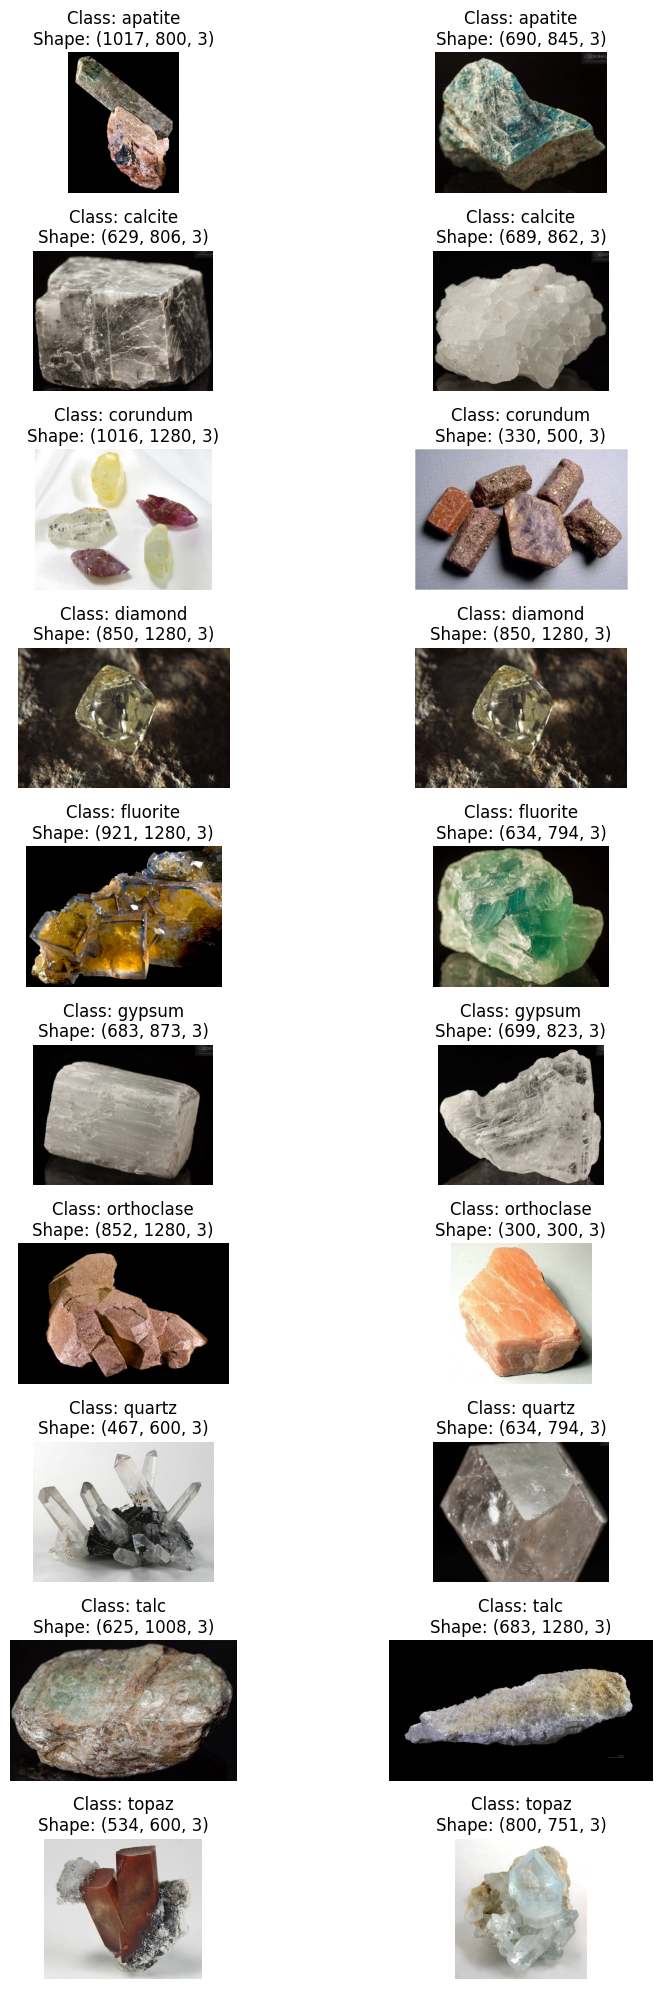

In [6]:
NUM_IMAGES = 2
fig, axes = plt.subplots(nrows=len(CLASSES), ncols=NUM_IMAGES, figsize=(9, 20))
p = 0
for c in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, c)).glob("*.png"))
    images_selected = random.choices(total_images_class, k=NUM_IMAGES)
    
    for i, img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axes[p, i].imshow(img_rgb)
        axes[p, i].axis('off')
        axes[p, i].set_title(f'Class: {c}\nShape: {img_rgb.shape}')
        
    p += 1
    
fig.tight_layout()
plt.show()

In [7]:
images_paths = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

In [8]:
for i, img_path in enumerate(IMAGE_PATH_LIST):
    images_paths[i] = img_path
    labels[i] = img_path.parent.stem

In [9]:
data = pd.DataFrame({'Path': images_paths, 'Label': labels})
data.head()


,Path,Label
0,/kaggle/input/mineral-classification/img/apati...,apatite
1,/kaggle/input/mineral-classification/img/talc/...,talc
2,/kaggle/input/mineral-classification/img/talc/...,talc
3,/kaggle/input/mineral-classification/img/talc/...,talc
4,/kaggle/input/mineral-classification/img/quart...,quartz


In [10]:
label_map = dict(zip(CLASSES, range(len(CLASSES))))
print(label_map)

{'apatite': 0, 'calcite': 1, 'corundum': 2, 'diamond': 3, 'fluorite': 4, 'gypsum': 5, 'orthoclase': 6, 'quartz': 7, 'talc': 8, 'topaz': 9}


In [11]:
bootstrap_samples = 30

data_bootstrap = []

for _ in tqdm(range(bootstrap_samples)):
    bootstrap_sample = data.sample(n=len(data), replace=True)
    data_bootstrap.append(bootstrap_sample)

# We visualize the number of samples per class.
data_new = pd.concat(data_bootstrap, ignore_index=True)
data_new['Label'].value_counts()


  0%|          | 0/30 [00:00<?, ?it/s]

Label
fluorite      369
quartz        304
calcite       236
gypsum        200
talc          166
apatite       162
topaz         160
diamond       100
orthoclase    100
corundum       63
Name: count, dtype: int64

In [12]:
# Define the random seed for reproducibility
SEED = 42
data_train, data_rest = tts(data_new, 
                            test_size=0.3, 
                            random_state=SEED, 
                            stratify=data_new['Label'])

data_val, data_test = tts(data_rest, 
                          test_size=0.5, 
                          random_state=SEED, 
                          stratify=data_rest['Label'])


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label_map: dict, transforms):
        self.df = df
        self.label_map = label_map
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = self.label_map[label]
        return image, label

# Transformation
auto_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(data_train, label_map, auto_transforms)
val_dataset = CustomImageDataset(data_val, label_map, auto_transforms)
test_dataset = CustomImageDataset(data_test, label_map, auto_transforms)

BATCH_SIZE = 24
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS)

val_dataloader = DataLoader(dataset=val_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=NUM_WORKERS)


In [14]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNNModel(nn.Module):
    def __init__(self, output_shape):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Assuming input images are 224x224
        self.fc2 = nn.Linear(128, output_shape)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_cnn_model(model, train_loader, val_loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader)}, Train Acc: {train_acc}, Val Loss: {val_loss/len(val_loader)}, Val Acc: {val_acc}')
    
    return model

# Initialize and train the CNN model
output_shape = len(CLASSES)
cnn_model = CNNModel(output_shape).to(device)
trained_cnn_model = train_cnn_model(cnn_model, train_dataloader, val_dataloader)


Epoch: 0, Train Loss: 1.6962058355862444, Train Acc: 59.67741935483871, Val Loss: 0.17430607105294862, Val Acc: 95.6989247311828
Epoch: 1, Train Loss: 0.0748809455555271, Train Acc: 98.23348694316437, Val Loss: 0.009568945233089229, Val Acc: 100.0
Epoch: 2, Train Loss: 0.0011416150886692446, Train Acc: 100.0, Val Loss: 0.00044678642370854504, Val Acc: 100.0
Epoch: 3, Train Loss: 0.0003140888528750193, Train Acc: 100.0, Val Loss: 0.0002858213495831781, Val Acc: 100.0
Epoch: 4, Train Loss: 0.00021758447454141622, Train Acc: 100.0, Val Loss: 0.00020494553306586263, Val Acc: 100.0


In [15]:
def evaluate_cnn_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

cnn_accuracy, cnn_predictions, cnn_labels = evaluate_cnn_model(trained_cnn_model, test_dataloader)
print(f"CNN Accuracy: {cnn_accuracy:.2f}%")


CNN Accuracy: 100.00%


In [16]:
def preprocess_images(dataloader):
    images = []
    labels = []
    for batch_images, batch_labels in dataloader:
        for img, label in zip(batch_images, batch_labels):
            img = img.permute(1, 2, 0).numpy().flatten()  # Flatten the image
            images.append(img)
            labels.append(label.item())
    return np.array(images), np.array(labels)

X_train_flat, y_train_flat = preprocess_images(train_dataloader)
X_val_flat, y_val_flat = preprocess_images(val_dataloader)
X_test_flat, y_test_flat = preprocess_images(test_dataloader)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)


In [17]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_flat)
rf_accuracy = rf_model.score(X_test_scaled, y_test_flat)
rf_predictions = rf_model.predict(X_test_scaled)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")


# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train_flat)
svm_accuracy = svm_model.score(X_test_scaled, y_test_flat)
svm_predictions = svm_model.predict(X_test_scaled)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

# k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_flat)
knn_accuracy = knn_model.score(X_test_scaled, y_test_flat)
knn_predictions = knn_model.predict(X_test_scaled)
print(f"k-NN Accuracy: {knn_accuracy * 100:.2f}%")


Random Forest Accuracy: 100.00%
SVM Accuracy: 100.00%
k-NN Accuracy: 100.00%


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_flat)
lr_accuracy = lr_model.score(X_test_scaled, y_test_flat)
lr_predictions = lr_model.predict(X_test_scaled)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train_flat)
dt_accuracy = dt_model.score(X_test_scaled, y_test_flat)
dt_predictions = dt_model.predict(X_test_scaled)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

# Extra Trees Classifier
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train_scaled, y_train_flat)
et_accuracy = et_model.score(X_test_scaled, y_test_flat)
et_predictions = et_model.predict(X_test_scaled)
print(f"Extra Trees Classifier Accuracy: {et_accuracy * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 100.00%
Decision Tree Accuracy: 100.00%
Extra Trees Classifier Accuracy: 100.00%


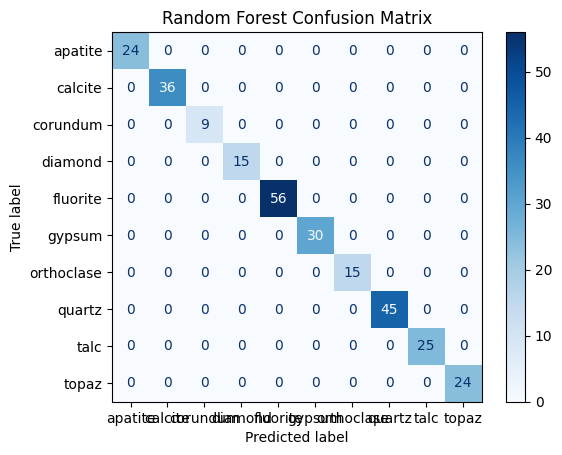

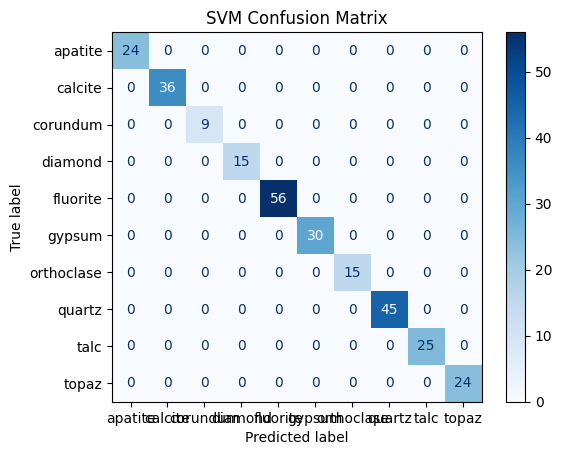

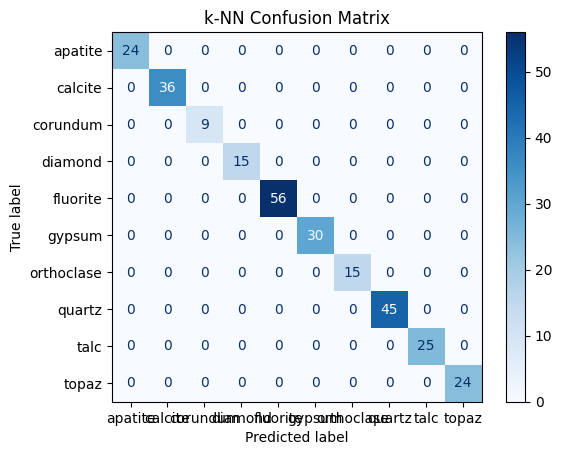

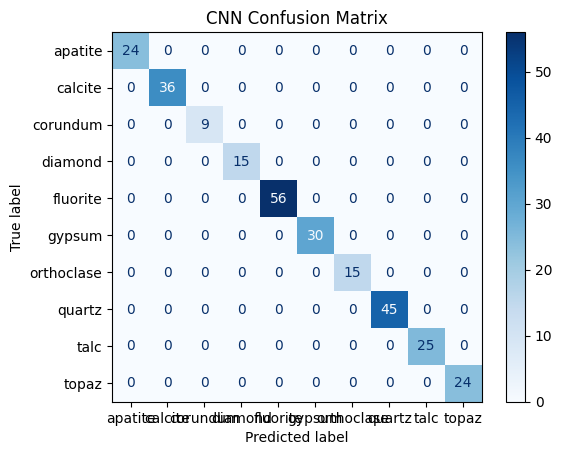

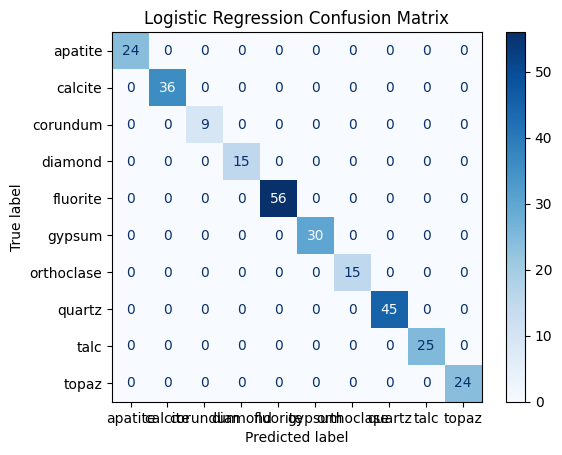

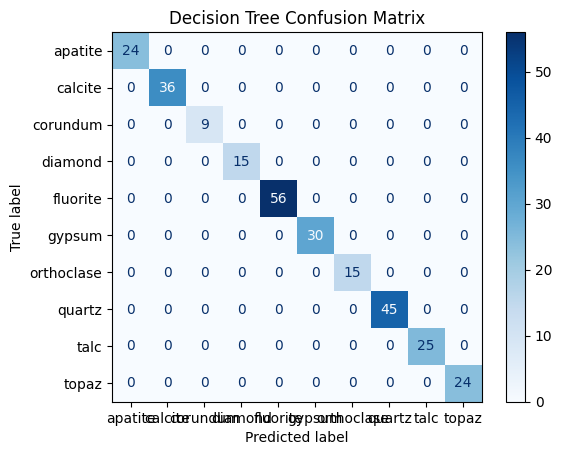

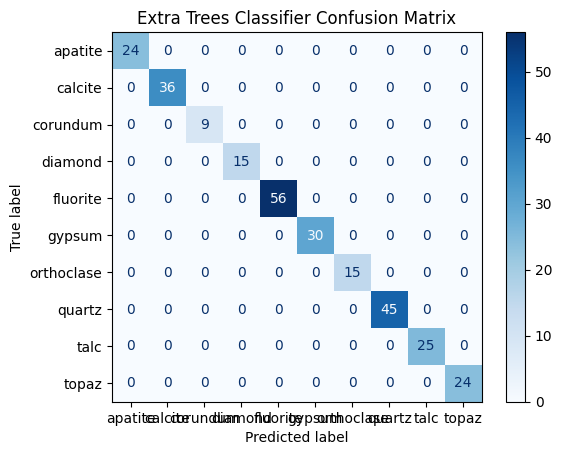

In [19]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test_flat, rf_predictions, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test_flat, svm_predictions, "SVM Confusion Matrix")
plot_confusion_matrix(y_test_flat, knn_predictions, "k-NN Confusion Matrix")
plot_confusion_matrix(cnn_labels, cnn_predictions, "CNN Confusion Matrix")
plot_confusion_matrix(y_test_flat, lr_predictions, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test_flat, dt_predictions, "Decision Tree Confusion Matrix")
plot_confusion_matrix(y_test_flat, et_predictions, "Extra Trees Classifier Confusion Matrix")



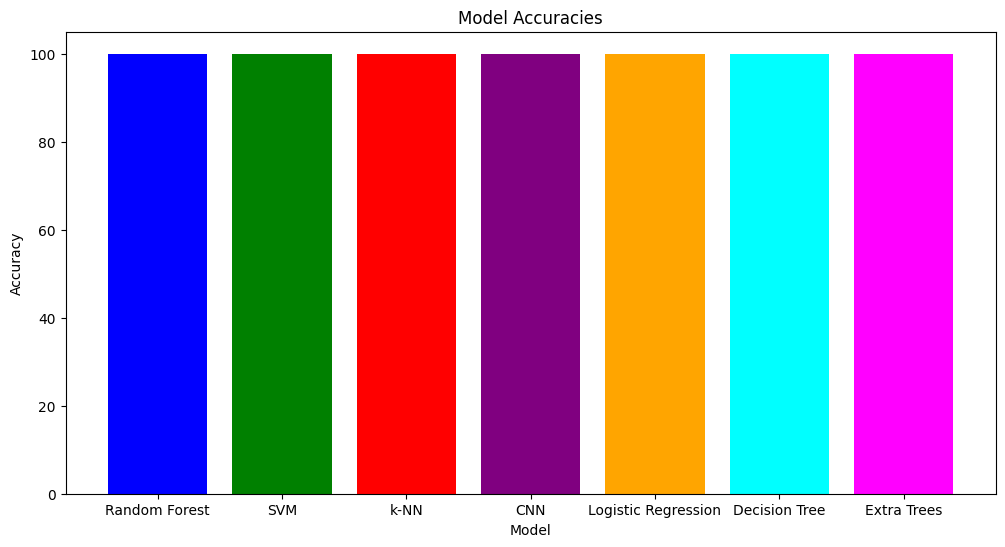

In [20]:
# Calculate and store accuracy scores for each model
accuracies = {
    "Random Forest": rf_accuracy*100,
    "SVM": svm_accuracy*100,
    "k-NN": knn_accuracy*100,
    "CNN": cnn_accuracy,
    "Logistic Regression": lr_accuracy*100,
    "Decision Tree": dt_accuracy*100,
    "Extra Trees": et_accuracy*100
}

# Plot the accuracy scores
plt.figure(figsize=(12, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()


In [22]:
import pickle

# Assuming `model` is your trained model
with open('mineral_classificiation_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
